### Conditional GAN on MNIST

Code available at : https://github.com/wiseodd/generative-models/blob/master/GAN/conditional_gan/cgan_pytorch.py

In [8]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import input_data

In [10]:
# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
cnt = 0
lr = 1e-3

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [11]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [12]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [13]:

""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X, c):
    inputs = torch.cat([X, c], 1)
    h = nn.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

Iter-0; D_loss: 0.6863559484481812; G_loss: 1.814175009727478


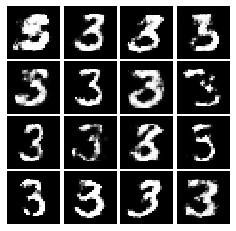

Iter-5000; D_loss: 0.80482017993927; G_loss: 1.6973114013671875


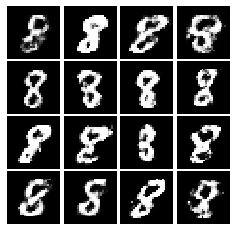

Iter-10000; D_loss: 0.5003962516784668; G_loss: 2.296926498413086


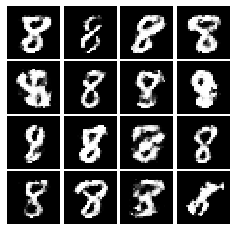

Iter-15000; D_loss: 0.6792681217193604; G_loss: 2.2069103717803955


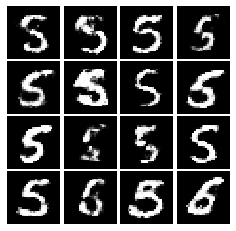

In [19]:
""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1))
zeros_label = Variable(torch.zeros(mb_size, 1))


for it in range(20000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    X, c = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))
    c = Variable(torch.from_numpy(c.astype('float32')))

    # Dicriminator forward-loss-backward-update
    G_sample = G(z, c)
    D_real = D(X, c)
    D_fake = D(G_sample, c)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z, c)
    D_fake = D(G_sample, c)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 5000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        c = np.zeros(shape=[mb_size, y_dim], dtype='float32')
        c[:, np.random.randint(0, 10)] = 1.
        c = Variable(torch.from_numpy(c))
        samples = G(z, c).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

#         if not os.path.exists('out/'):
#             os.makedirs('out/')

#         plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
#         cnt += 1
#         plt.close(fig)

        plt.show()

In [ ]:
write on your skills forge